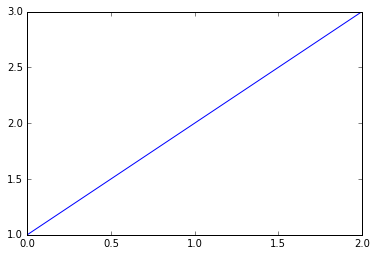

In [1]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import expm # matrix exponential solves linear system
import matplotlib.pyplot as plt
from time import sleep
%matplotlib inline

plt.figure()
plt.plot([1,2,3])

In [2]:
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
#from JSAnimation import IPython_display
#from matplotlib import animation

N = 100 # number of compartments
x = np.linspace(0,1,N) # position along cable
DC = 0.5 # diffusion coeff (normalized to compartment length)

def get_target_profile(n_syn,syn_loc=None):
    # Calculate target profile, y
    if syn_loc is None: syn_loc = np.linspace(0.1,0.9,n_syn)
    x = np.linspace(0,1,N)
    y = np.zeros(N)
    for i in syn_loc:
        y += 0.5*np.exp(-abs(x - x[int(i*N)])*100)
    return y

def get_matrix(y,c_scale,d_scale,bias=0.0):
    """Calculates the state-transition matrix, A"""
    
    # detachment rates
    c = c_scale*y
    
    # reattachment rates
    d = d_scale*np.ones(N)
    
    # trafficking rates, constrain so that a+b = DC/2
    a = np.linspace((DC/2.)+bias,(DC/2.),N-1)
    b = np.linspace((DC/2.)-bias,(DC/2.),N-1)
    
    # State-transition matrix:
    # 
    # A = [ A1 | A2
    #       A3 | A4 ]
    mid = -c
    mid[:-1] -= a
    mid[1:]  -= b
    A1 = np.diag(a, -1) + np.diag(mid) + np.diag(b, 1) # movement on microtubules, detaching cargo lost
    A2 = np.diag(d) # reattaching cargo recieved at microtubules
    A3 = np.diag(c) # detaching cargo recieved at synapses
    A4 = -np.diag(d) # reattaching cargo lost at synapses 
    
    # State-transition matrix
    A = np.array(np.bmat([[A1,A2],[A3,A4]]))
    
    # initial condition
    u0 = np.zeros(2*N)
    u0[0] = np.sum(y)
    
    return A,u0

def sim(cs,ds,t,n_syn=6,bias=0.0,filename=None):
    y = get_target_profile(n_syn)#np.ones(N)/N
    A,u0 = get_matrix(y,cs,ds,bias)
    
    if filename is not None:
        save_snapshots(A,u0,filename)
    
    # animation figure
    fig = plt.figure()
    ax1 = plt.subplot(2,1,1)
    plt.title('concentration on microtubule')
    line1, = ax1.plot([],[],lw=2)
    plt.ylim([-0.02,0.2]),plt.xlim([0,1])
    ax2 = plt.subplot(2,1,2)
    plt.title('detached concentration')
    line2, = ax2.plot([],[],lw=2)
    plt.ylim([-0.02,1.0]),plt.xlim([0,1])
    plt.tight_layout()

    def init():
        line1.set_data(x, u0[:N])
        line2.set_data(x, u0[N:])
        return line1,line2,

    def animate(i):
        u = np.dot(expm(A*t[i]),u0)
        line1.set_data(x, u[:N])
        line2.set_data(x, u[N:])
        ax1.set_title('concentration on microtubule: '+str(np.round(t[i]/60))+' mins')
        ax2.set_title('detached concentration: '+str(np.round(100*np.sum(u[N:])/np.sum(u),2))+'% detached')
        return line1,line2,
        
    return fig,animate,init

def save_snapshots(A,u0,filename):
    u75 = np.dot(expm(A*(75*60)),u0)
    u245 = np.dot(expm(A*(245*60)),u0)
    uss = np.dot(expm(A*(1440*60)),u0) # steady-state profile
    names = ['75mins','245mins','1 day']

    for u,n in zip([u75,u245,uss],names):
        plt.figure()
        plt.title(n)
        plt.plot(x,u[:N],'-b',lw=2)
        plt.plot(x,u[N:],'-r',lw=2)
        plt.ylim([-0.02,1.3]),plt.xlim([0,1])
        plt.legend(('on microtubule','detached'))
        plt.tight_layout()
        plt.savefig(filename+'_'+n+'.svg')
        plt.close()

def calc_tradeoff_curve(y,cs):
    tau,excess = [],[]
    for ds in np.logspace(-2,0,5):
        A,u0 = get_matrix(y,cs,ds*cs)
        tss,uss = calc_time_to_ss(A)
        uss = np.dot(expm(A*10*tss),u0) # steady-state profile
        excess.append(np.sum(uss[:N])/np.sum(uss))
        tau.append(tss)
    return np.array(tau),np.array(excess)

def calc_time_to_ss(A,ss_tol=1e-6,bound_tol=1.0):
    # calculate number of seconds to reach steady-state (within tol)
    u0 = np.ones(N*2)
    u0[0] = 1.0
    
    tt = 1.0
    u = np.dot(expm(A*tt),u0)
    upper_bound,lower_bound = 1e10,0.0
    while (upper_bound - lower_bound) > bound_tol:
        tt = lower_bound + (upper_bound-lower_bound)/2
        u = np.dot(expm(A*tt),u0)
        if np.linalg.norm(np.dot(A,u))/np.sqrt(N) > ss_tol:
            # not converged to steady-state
            lower_bound = tt
        else:
            # converged to steady-state
            upper_bound = tt
    tss = lower_bound + (upper_bound-lower_bound)/2
    return tss,np.dot(expm(A*tss*10),u0)

def err_vs_time(cs,ds,n_syn=6,bias=0.0,tmax=5.5):
    y = get_target_profile(n_syn)#np.ones(N)/N
    A,u0 = get_matrix(y,cs,ds,bias)
    u0[1] = 1.0
    uss = np.dot(expm(A*(10**(tmax+1))),u0)
    t = np.logspace(1.5,tmax,tmax*6)
    err,excess = [],[] 
    for tt in t:
        u = np.dot(expm(A*tt),u0)
        #err.append(np.mean( 100*np.abs(u[N:]-uss[N:])/u[N:] ))
        err.append( 100*np.mean( np.abs(u[N:]-uss[N:])/uss[N:]) )
        excess.append( 100*np.sum(u[:N])/np.sum(u) )
    return t,err,excess

In [4]:
y = get_target_profile(6)
cs = 0.0001
A,u0 = get_matrix(y,cs,cs)

In [ ]:
np.dot(expm(A),u0)

In [ ]:
A